In [47]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import eval_unlooped_model, aggregate_metrics, eval_looped_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [3]:
device = torch.device('cuda:0')

In [4]:
def get_model(model, result_dir, run_id, step, best=False):
    if best:
        model_path = os.path.join(result_dir, run_id, 'model_best.pt')
        state_dict = torch.load(model_path, map_location='cpu')['state_dict']
        best_err = torch.load(model_path, map_location='cpu')['loss']
        print("saved model with loss:", best_err)
    if step == -1:
        model_path = os.path.join(result_dir, run_id, 'state.pt')
        state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']
    else:
        model_path = os.path.join(result_dir, run_id, 'model_{}.pt'.format(step))
        state_dict = torch.load(model_path, map_location='cpu')['model']
    
#     return state_dict
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=True)
    
    return model


## Get dataset

In [13]:
class LinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None):
        super(LinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1) if w_star is None else w_star.to(device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b.to(device)
        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 10

real_task = LinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

## load unlooped model

In [12]:
result_dir = '../results2/linear_regression_baseline'
run_id = '0627142823-LR_baseline_noclip-f61e'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, y_pred_total = eval_unlooped_model(model, xs, ys)


number of parameters: 9.48M


In [146]:
result_errs = {}
#result_errs['Transformer'] = err

## Load looped transformer with optimal b

In [7]:
from models import TransformerModelLooped

In [145]:
def eval(run_id, n_layer=1, use_n_last=-1, use_ctx_mult=False, ssm_config=None):
    result_dir = '../results2/linear_regression_loop'

    n_positions = 101
    n_embd = 256
    n_head = 8
    T = 500

    model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head, use_ctx_mult=use_ctx_mult, ssm_config=ssm_config)
    step = 19999
    model = get_model(model, result_dir, run_id, step)
    model = model.to(device)
        
    err, loop_err = eval_looped_model(model, xs, ys, loop_max=T, use_n_last=use_n_last)

    result_errs[run_id] = err

In [147]:
eval('0627153318-LR_loop_L1_ends{30}_T{15}-d886', n_layer=1, use_n_last=41, use_ctx_mult=False)

number of parameters: 0.79M
41
0


In [150]:
from collections import namedtuple
SSMConfig = namedtuple("SSMConfig", ["enable", "d_state", "d_conv", "expand"])

In [151]:
ssm_config = SSMConfig(enable=True, d_state=16, d_conv=4, expand=2)
eval('0703113240-LR_loop_L1_ssm_ends{30}_T{15}-de0c', n_layer=1, use_n_last=41, use_ctx_mult=False, ssm_config=ssm_config)

number of parameters: 0.96M
41
0


In [152]:
ssm_config = SSMConfig(enable=True, d_state=4, d_conv=4, expand=1)
eval('0703131232-LR_loop_L1_ssm_dstate{4}_ends{30}_T{15}-4f95', n_layer=1, use_n_last=41, use_ctx_mult=False, ssm_config=ssm_config)

number of parameters: 0.74M
41
0


In [153]:
ssm_config = SSMConfig(enable=True, d_state=64, d_conv=4, expand=1)
eval('0703134441-LR_loop_L1_ssm_dstate{64}_ends{30}_T{15}-7909', n_layer=1, use_n_last=41, use_ctx_mult=False, ssm_config=ssm_config)

number of parameters: 0.78M
41
0


In [154]:
ssm_config = SSMConfig(enable=True, d_state=64, d_conv=4, expand=2)
eval('0703151037-LR_loop_L1_ssm_dstate{64}_expand{2}_ends{30}_T{15}-3642', n_layer=1, use_n_last=41, use_ctx_mult=False, ssm_config=ssm_config)

number of parameters: 1.04M
41
0


In [155]:
ssm_config = SSMConfig(enable=True, d_state=64, d_conv=4, expand=4)
eval('0703151107-LR_loop_L1_ssm_dstate{64}_expand{4}_ends{30}_T{15}-203c', n_layer=1, use_n_last=41, use_ctx_mult=False, ssm_config=ssm_config)

number of parameters: 1.55M
41
0


In [138]:
eval('0704181451-LR_loop_L1_ctxmult_ends{30}_T{15}-f009', n_layer=1, use_n_last=41, use_ctx_mult=True)

number of parameters: 0.79M
41
0


In [29]:
eval('0627170930-LR_loop_L2_ends{30}_T{15}-8e54', n_layer=2)

number of parameters: 1.58M
0


In [74]:
eval('0627175645-LR_loop_L3_ends{30}_T{15}-1c17', n_layer=3)

number of parameters: 2.37M
0


In [31]:
eval('0627180713-LR_loop_L4_ends{30}_T{15}-dd74', n_layer=4)

number of parameters: 3.16M
0


In [33]:
eval('0627180933-LR_loop_L5_ends{30}_T{15}-b5bb', n_layer=5)

number of parameters: 3.95M
0


In [106]:
eval('0704141018-LR_loop_L1_half_last_ends{30}_T{15}-fb68', n_layer=1, use_n_last=41 // 2)

number of parameters: 0.79M
20
0


In [108]:
eval('0704142023-LR_loop_L1_3/4_last_ends{30}_T{15}-868c', n_layer=1, use_n_last=3 * 41 // 4)

number of parameters: 0.79M
30
0


In [109]:
eval('0704142114-LR_loop_L1_1/4_last_ends{30}_T{15}-fe98', n_layer=1, use_n_last=1 * 41 // 4)

number of parameters: 0.79M
10
0


In [157]:
result_errs.keys()

dict_keys(['0627153318-LR_loop_L1_ends{30}_T{15}-d886', '0703113240-LR_loop_L1_ssm_ends{30}_T{15}-de0c', '0703131232-LR_loop_L1_ssm_dstate{4}_ends{30}_T{15}-4f95', '0703134441-LR_loop_L1_ssm_dstate{64}_ends{30}_T{15}-7909', '0703151037-LR_loop_L1_ssm_dstate{64}_expand{2}_ends{30}_T{15}-3642', '0703151107-LR_loop_L1_ssm_dstate{64}_expand{4}_ends{30}_T{15}-203c'])

### Also get the "weak" baseline

In [15]:
from utils import get_relevant_baselines

baselines = get_relevant_baselines("linear_regression")
# baseline_errs = {}
for baseline_model in baselines:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [158]:
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)

In [51]:
sns.set_style("darkgrid")

In [89]:
from matplotlib import cm

In [159]:
result_errs_agg_list = list(result_errs_agg.items())

In [161]:
[x[0] for x in result_errs_agg_list]

['0627153318-LR_loop_L1_ends{30}_T{15}-d886',
 '0703113240-LR_loop_L1_ssm_ends{30}_T{15}-de0c',
 '0703131232-LR_loop_L1_ssm_dstate{4}_ends{30}_T{15}-4f95',
 '0703134441-LR_loop_L1_ssm_dstate{64}_ends{30}_T{15}-7909',
 '0703151037-LR_loop_L1_ssm_dstate{64}_expand{2}_ends{30}_T{15}-3642',
 '0703151107-LR_loop_L1_ssm_dstate{64}_expand{4}_ends{30}_T{15}-203c']

In [162]:
model_names = ["Attention", "SSM(d_state=16, expand=2)", "SSM(d_state=4, expand=1)", "SSM(d_state=64, expand=1)", "SSM(d_state=64, expand=2)", "SSM(d_state=64, expand=4)"]

Text(0, 0.5, 'log err')

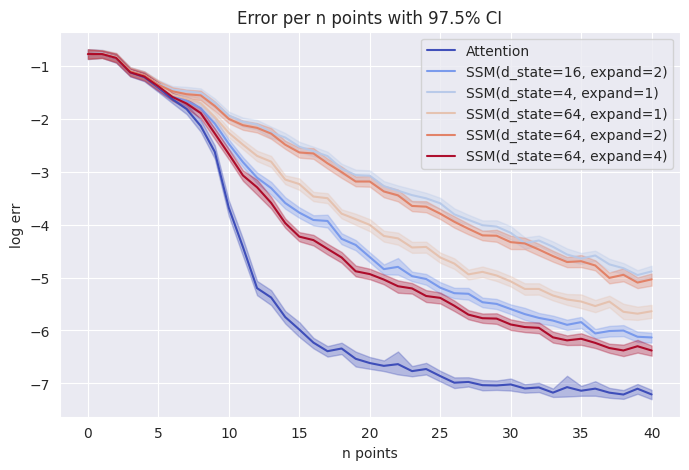

In [163]:
fig, ax = plt.subplots(figsize=fig_hparam['figsize'])
colors = 0.95 * cm.coolwarm(np.linspace(0, 1, len(result_errs_agg)))

for color, model_name, metrics in zip(colors, model_names, result_errs_agg_list):
    metrics = metrics[1]
    x = np.arange(metrics['mean'].shape[0])
    mean = metrics['mean'].numpy()
    std = metrics['std'].numpy()

    sns.lineplot(x=x, y=np.log(mean), ax=ax, label=model_name, color=color)
    
    low = metrics["bootstrap_low"]
    high = metrics["bootstrap_high"]
    ax.fill_between(x, np.log(low), np.log(high), color=color, alpha=0.3)

ax.set_title("Error per n points with 97.5% CI")
ax.set_xlabel("n points")
ax.set_ylabel("log err")

In [36]:
result_errs_agg

{'0627153318-LR_loop_L1_ends{30}_T{15}-d886': {'mean': tensor([0.4603, 0.4604, 0.4270, 0.3300, 0.2958, 0.2446, 0.1949, 0.1633, 0.1187,
          0.0720, 0.0267, 0.0113, 0.0063, 0.0050, 0.0032, 0.0026, 0.0021, 0.0020,
          0.0019, 0.0016, 0.0014, 0.0013, 0.0015, 0.0012, 0.0013, 0.0012, 0.0011,
          0.0009, 0.0010, 0.0009, 0.0009, 0.0009, 0.0010, 0.0009, 0.0009, 0.0009,
          0.0009, 0.0008, 0.0009, 0.0009, 0.0008]),
  'std': tensor([0.9031, 0.7026, 0.7383, 0.5121, 0.4883, 0.4217, 0.3242, 0.3341, 0.2735,
          0.1773, 0.0878, 0.0379, 0.0199, 0.0159, 0.0085, 0.0066, 0.0048, 0.0046,
          0.0057, 0.0036, 0.0030, 0.0030, 0.0066, 0.0027, 0.0032, 0.0025, 0.0038,
          0.0018, 0.0021, 0.0022, 0.0022, 0.0015, 0.0023, 0.0016, 0.0043, 0.0019,
          0.0024, 0.0015, 0.0016, 0.0017, 0.0019]),
  'bootstrap_low': tensor([0.4205, 0.4288, 0.3957, 0.3074, 0.2736, 0.2253, 0.1806, 0.1489, 0.1072,
          0.0642, 0.0229, 0.0095, 0.0054, 0.0043, 0.0029, 0.0023, 0.0019, 0.0018,

In [18]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Looped Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging'])

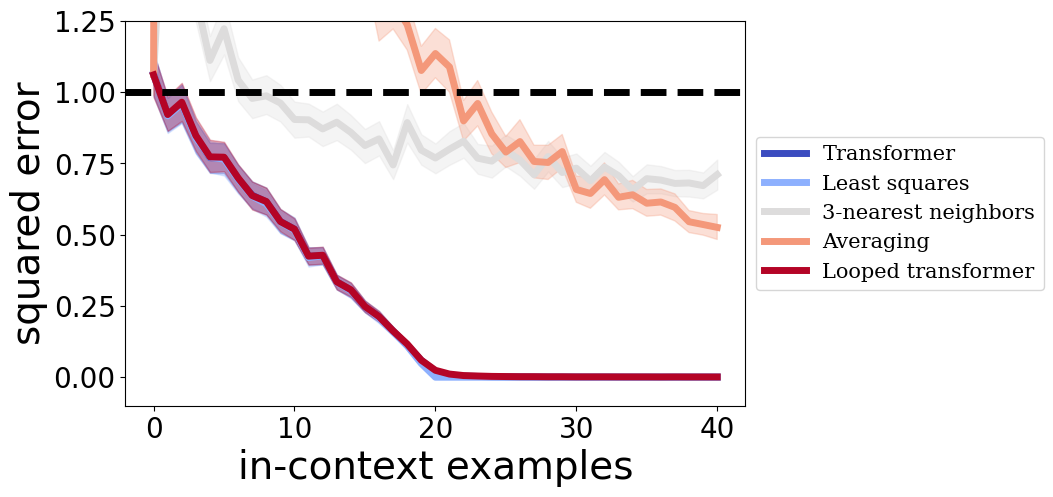

In [19]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")
result_name_list = ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Looped Transformer']  # , 
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.25)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])


# plt.savefig("result_folder/Figures/LR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')

In [ ]:
from mamba_ssm import Mamba

